In [1]:
#
# Chapter 7, example 4
#

import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers, models
import pylab
import utils

# Check the version of Tensorflow (2.2.0)
print(tf.__version__)

# import os
# if not os.path.isdir('figures'):
#     print('creating the figures folder')
#     os.makedirs('figures')

2.2.0


In [2]:
# Load and prepare the MNIST dataset. 
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# choose 12000 images for training, 2000 images for testing
x_train,y_train = x_train[:12000],y_train[:12000]
x_test,y_test = x_test[:2000],y_test[:2000]
# Convert the samples from integers to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)
# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(12000, 28, 28)
(2000, 28, 28)
(12000, 28, 28, 1)
(2000, 28, 28, 1)


In [3]:
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)

In [4]:
# Built Model
tf.keras.backend.set_floatx('float64')
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # Convert the samples from integers to [0,1]
        # layers.experimental.preprocessing.Rescaling(1./255, input_shape=(28, 28, 1)),
        # First convolutional layer - maps one grayscale image to 32 feature maps.
        self.conv1 = layers.Conv2D(32, 5, padding='SAME', activation='relu', use_bias=True)
        # First Pooling layer - downsamples by 2X.
        self.p1 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='SAME')
        # Second convolutional layer -- maps 32 feature maps to 64.
        self.conv2 = layers.Conv2D(64, 5, padding='SAME', activation='relu', use_bias=True)
        # Second Pooling layer - downsamples by 2X.
        self.p2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='SAME')
        # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
        # is down to 7x7x64 feature maps -- maps this to 1024 features.
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(1024, activation='relu')
        # dropout layer
        self.drop = tf.keras.layers.Dropout(0.2)
        # softmax
        self.d2 = layers.Dense(10, activation='softmax')
    def call(self, x):
        conv1 = self.conv1(x)
        p1 = self.p1(conv1)
        conv2 = self.conv2(p1)
        p2 = self.p2(conv2)
        flatten = self.flatten(p2)
        d1 = self.d1(flatten)
        drop = self.drop(d1)
        out = self.d2(drop)
        return out


In [5]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [6]:
# Choose anloss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
# Train step
# @tf.function
def train_step(images, labels, myoptimizer):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    if myoptimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    elif myoptimizer == 'Momentum':
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9)
    elif myoptimizer == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=1e-3)
    elif myoptimizer == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
    elif myoptimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    else:
        print("Wrong optimizer type")

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [7]:
# Test step
# @tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

0881594594942, Accuracy: 0.9979166666666667, Test Loss: 0.24966805110852874, Test Accuracy: 0.9815
Epoch 30, Loss: 0.02859872050161045, Accuracy: 0.99775, Test Loss: 0.2748361522241112, Test Accuracy: 0.9805
Epoch 31, Loss: 0.024034566032801824, Accuracy: 0.99825, Test Loss: 0.3373459114227444, Test Accuracy: 0.9765
Epoch 32, Loss: 0.03528385992577276, Accuracy: 0.9973333333333333, Test Loss: 0.32276098904549144, Test Accuracy: 0.978
Epoch 33, Loss: 0.03264216560065153, Accuracy: 0.9975833333333334, Test Loss: 0.23563590906179144, Test Accuracy: 0.984
Epoch 34, Loss: 0.029546126659867958, Accuracy: 0.9978333333333333, Test Loss: 0.3316486896947026, Test Accuracy: 0.976
Epoch 35, Loss: 0.028745225173915943, Accuracy: 0.9980833333333333, Test Loss: 0.2639146351721138, Test Accuracy: 0.98
Epoch 36, Loss: 0.035665113938467156, Accuracy: 0.99725, Test Loss: 0.284909305645634, Test Accuracy: 0.9795
Epoch 37, Loss: 0.024012205756376265, Accuracy: 0.9980833333333333, Test Loss: 0.2584078473416

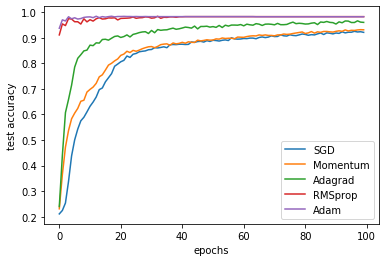

In [8]:
# Main function: train and test the model
EPOCHS = 100
pylab.figure()
for myoptimizer in ['SGD', 'Momentum', 'Adagrad', 'RMSprop', 'Adam']:
    # Create an instance of the model
    model = MyModel()
    print('Training with: '+myoptimizer+'...')
    test_acc = []
    for epoch in range(EPOCHS):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for images, labels in train_ds:
            train_step(images, labels, myoptimizer)

        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

        test_acc.append(test_accuracy.result())
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result(),
                              test_loss.result(),
                              test_accuracy.result()))

    pylab.plot(np.arange(EPOCHS), test_acc, label= myoptimizer)

pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')
pylab.savefig('./figures/7.4_1.png')
